# Explore RAST Metadata

I have abstracted this out because we need some new functions, and so I want a clean notebook. Will merge with the RAST notebook later!

In [1]:
import os
import sys

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from scipy.stats import pearsonr, f_oneway, entropy
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

# for parsing collection dates
from dateutil.parser import parse, ParserError
import pytz

import subprocess
import gzip


## Date conversion

From the RAST notebook. Should make a library for this!

In [2]:

# Convert the collection date to a number. We take todays date, and then convert relative to that
# it allows dates pre-epoch

yr = re.compile("^[~]*(\\d{4})['s]*$") # eg ~1970's
yrrange = re.compile("^(\\d{4})\\s*.\\s*(\\d{4})$") # eg 2001-2002
myd = re.compile('^\\d{1,4}/\\d{1,2}/\\d{1,4}$') # eg 2/3/21
moyr = re.compile('^\\w{3}-\\d{2}$') # eg Dec-09 should be 01-Dec-09 else parsed as 9th Dec this year
damoyrrange = re.compile('^(\\d+\\s+\\w+\\s+\\d{4})\\s*.{1,3}?\\s*(\\d+\\s+\\w+\\s+\\d{4})$') 
modacyrrange = re.compile('^(\\w+\\s+\\d+,*\\s+\\d{4})\\s*.{1,3}?\\s*(\\w+\\s+\\d+,*\\s+\\d{4})$')
moyrrange = re.compile('^(\\w+\\s+\\d{4})\\s*.{1,3}?\\s*(\\w+\\s+\\d{4})$')
year42 = re.compile('^(\\d{4})-\\d{2}$')
lem = re.compile("^late\\s*|^early\\s*|^mid\\s*|^prior to\\s*|^before\\s*|^pre-", re.IGNORECASE)
splitseen = set()

try:
    # adate = parse("24/02/1977")
    adate = parse("1/1/0001")
except ParserError as e:
    sys.stderr.write("Error parsing adate: {e}\n")
    sys.exit(1)
    
adate = adate.replace(tzinfo=pytz.UTC)

def try_parsing(x):
    """
    Attempt to parse a date, and catch an error.
    
    If we fail, we return None, otherwise we return the years since now()
    """
    try:
        dt = parse(x)
    except:
        return None
    
    dt = dt.replace(tzinfo=pytz.UTC)
    
    if dt < adate:
        tdelt = adate - dt
        seconds = -1 * ((tdelt.days * 86400) + tdelt.seconds)
    else:
        tdelt = dt - adate
        seconds = (tdelt.days * 86400) + tdelt.seconds
    # convert seconds to years
    # then we add one because our epoch is now Jan 1, 0001
    return (seconds/31557600)+1
    

def convert_date(x, verbose=False):
    """
    Convert the date to years and fractions.
    
    We try several times, and clean it up as we go along.    
    
    :param x: the date string to convert
    :param verbose: more output information
    """
    if pd.isna(x):
        return np.nan
    
    # we need to fix this before trying to parse
    m = moyr.match(x)
    if m:
        x = '01-' + x

    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        if verbose:
            sys.stderr.write("Parsed at step 1\n")
        return attempt
    orix = x
    
    if x.lower() in ['restricted access', 'none', 'not collected', 'not applicable', 
                     'not available: not collected', 'unspecified']:
        return np.nan
   
    # a few one off cases that are just easier to fix
    if 'May 2015-Nov 2015' == x:
        x = 'May 2015'
    
    if '1954-65' == x:
        x = '01 January 1954'
        
    if 'Jul-00' == x:
        x = 'Jul-2000'

    if '2015_9' == x:
        x = 'Sep-2015'
    
    if '31-Mac-2013' == x:
        x = '31-May-2013'
    
    if '2010-0916' == x:
        x = '16 Sep 2010'
     
    x = lem.sub('', x)
    
        
    if '_' in x:
        x = x.replace('_', '-')
        
    x = x.replace(' or earlier', '')
    x = x.replace('collected in the ', '')
        
    # some regular expressions of variants of day month year - day month year ranges. We choose 1
    m = yrrange.match(x)
    if m:
        x = '01 January ' + m.groups()[1]

    m = yr.match(x)
    if m:
        x = '01 January ' + m.groups()[0]

    m = year42.match(x)
    if m:
        x = '01 January ' + m.groups()[0]
            
    m = modacyrrange.match(x)
    if m:
        x = m.groups()[1]
        
    m = damoyrrange.match(x)
    if m:
        x = m.groups()[1]
    
    m = moyrrange.match(x)
    if m:
        x = '01 ' + m.groups()[1]
        
    
        
    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        if verbose:
            sys.stderr.write(f"Parsed at step 2. Now {orix} is {x}\n")
        return attempt
          
    if '/' in x:
        if x not in splitseen:
            # sys.stderr.write(f"Splitting {x}\n")
            splitseen.add(x)
        p = x.split('/')
        x = p[1]
   
    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        if verbose:
            sys.stderr.write(f"Parsed at step 3. Now {orix} is {x}\n")
        return attempt
   
    if x.endswith('-00'):
        x = x.replace('-00', '-2000')

    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        if verbose:
            sys.stderr.write(f"Parsed at step 4. Now {orix} is {x}\n")
        return attempt

    
    sys.stderr.write(f"can't parse |{x}| from |{orix}|\n")
            
    return np.nan

## Read the metadata

We just use the small file for development, and then clean up a few known issues

In [3]:
use_small_data = False
if use_small_data:
    metadf = pd.read_csv("../small_data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
else:
    metadf = pd.read_csv("../data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
metadf['isolation_date'] = metadf.collection_date.apply(convert_date)
metadf = metadf.groupby('assembly_accession').first().reset_index()
metadf['isolation_country'] = metadf['isolation_country'].replace('USA', 'United States')
metadf['isolation_country'] = metadf['isolation_country'].replace('Ecully', 'France')

c:\workspace\edwa0468\githubs\phispyanalysis\venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,6,7,8,9,10,11,12,14,19,21,34,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
can't parse |1999 and 2000| from |1999 and 2000|
can't parse |0-Apr-2008| from |0-Apr-2008|
can't parse |CGMCC No.5392| from |CGMCC No.5392|
can't parse |CGMCC No.5392| from |CGMCC No.5392|


In [4]:
type(metadf['isolation_country'])

pandas.core.series.Series

# Theil's U

This work comes from [The Search For Categorical Correlation](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) and [The Dython Library](https://github.com/shakedzy/dython) but I have abstracted and simplified it here for my use

_Note_ I have now abstracted this into a class for use in the code

In [27]:
def handle_na(x):
    # return x.dropna()
    return x.fillna("")
    
def conditional_entropy(x, y, log_base: float = math.e):
    """
    Calculates the conditional entropy of x given y: S(x|y)

    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy

    Parameters:
    -----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    log_base: float, default = e
        specifying base for calculating entropy. Default is base e.

    Returns:
    --------
    float
    """
        
    # remove NaN 
    x = handle_na(x)
    y = handle_na(y)
    
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy



def theils_u(x, y):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-
    categorical association. This is the uncertainty of x given y: value is
    on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.

    This is an asymmetric coefficient: U(x,y) != U(y,x)

    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient

    Parameters:
    -----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
 
    Returns:
    --------
    float in the range of [0,1]
    """

    # remove NaN 
    x = handle_na(x)
    y = handle_na(y)
    
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x



In [6]:
theils_u(metadf['isolation_country'], metadf['geographic_location'])

0.3842220276592636

In [7]:
if False:
    hm = pd.DataFrame(index=metadf.columns, columns=metadf.columns, dtype=float)
    for i in range(len(metadf.columns)):
        for j in range(len(metadf.columns)):
            hm.iloc[i,j] = theils_u(metadf.iloc[:,i], metadf.iloc[:,j])
    sns.heatmap(hm)

In [33]:
acccol = 'assembly_accession'
interesting_cols = [acccol, 'isolation_site', 'geographic_location', 'isolation_country', 'latitude', 'longitude', 'altitude', 'depth',
                    'other_environmental', 'host_name', 'host_gender', 'host_age', 'host_health', 
                    'body_sample_site', 'body_sample_subsite', 'other_clinical', 'gram_stain', 'cell_shape',
                    'motility', 'sporulation', 'temperature_range', 'optimal_temperature', 'salinity',
                    'oxygen_requirement', 'habitat', 'disease', 'isolation_date']

hmi = pd.DataFrame(index=interesting_cols, columns=interesting_cols, dtype=float)
for i,j in enumerate(interesting_cols):
    for x,y in enumerate(interesting_cols):
        hmi.iloc[i,x] = theils_u(metadf.loc[:,j], metadf.loc[:,y])

<AxesSubplot:>

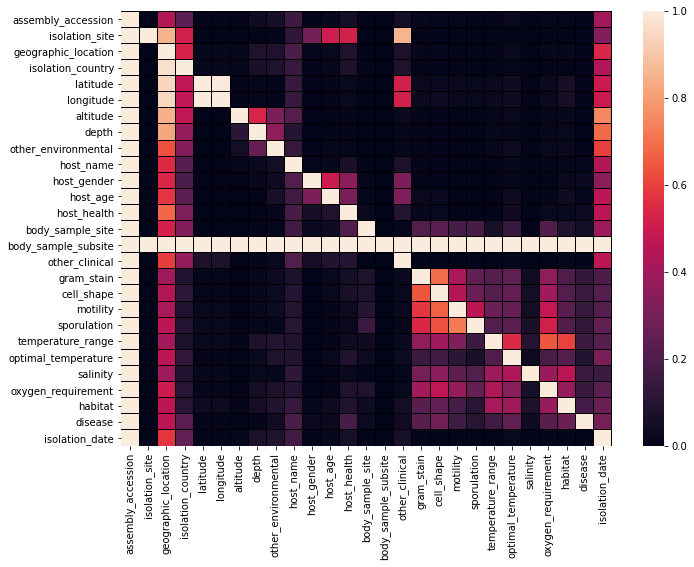

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
# sns.heatmap(hmi, cmap='Blues', ax=ax)
sns.heatmap(hmi, linecolor='k', linewidths=0.01, ax=ax)

In [38]:
col1 = 'other_clinical'
col2 = 'isolation_site'
u1 = theils_u(metadf.loc[:,col1], metadf.loc[:,col2])
u2 = theils_u(metadf.loc[:,col2], metadf.loc[:,col1])

print(f"{col1} vs {col2} {u1}")
print(f"{col2} vs {col1} {u2}")

if u1 > u2:
    print(f"This means that knowing the {col1} we have a lot of information about the {col2} ")
    print(f"but knowing the {col2} does not inform us about the {col1}")
else:
    print(f"This means that knowing the {col2} we have a lot of information about the {col1} ")
    print(f"but knowing the {col1} does not inform us about the {col2}")
    

other_clinical vs isolation_site 0.005078095497709224
isolation_site vs other_clinical 0.8588933773243586
This means that knowing the isolation_site we have a lot of information about the other_clinical 
but knowing the other_clinical does not inform us about the isolation_site


In [39]:
col1 = 'other_clinical'
col2 = 'isolation_site'
tmp = metadf[(metadf[col1].notnull()) & (metadf[col2].notnull())]

tmp[[col1, col2]]

,other_clinical,isolation_site
14557,hospital location:ICU,Respiratory
14558,hospital location:non-ICU,Urine
15424,hospital location:non-ICU,Urine
15426,hospital location:non-ICU,Urine
15430,hospital location:non-ICU,Urine
...,...,...
25222,"comorbidity:MDR-TB, HIV negative;treatment cou...",Sputum
25223,comorbidity:HIV negative;treatment course:adm,Sputum
25224,comorbidity:HIV positive;treatment course:adm,Sputum
25225,comorbidity:HIV negative;treatment course:adm,Sputum
